In [1]:
import pandas as pd

In [2]:
%run data_cleaning.ipynb
%run data_exploration.ipynb

## Data Visualization

In [3]:
import numpy as np
from plotnine import *
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
# import matplotlib as mpl

import matplotlib.dates as mdates
import datetime

%matplotlib inline
warnings.filterwarnings("ignore")

#### a. bar plot

In [4]:
barplot = combined_dataset.groupby(["out_airline_company", "arr_city"]).size().reset_index(name="N")
barplot

,out_airline_company,arr_city,N
0,Lufthansa,GRU,692
1,Lufthansa,JFK,568
2,Swiss,GRU,602
3,Swiss,JFK,1010


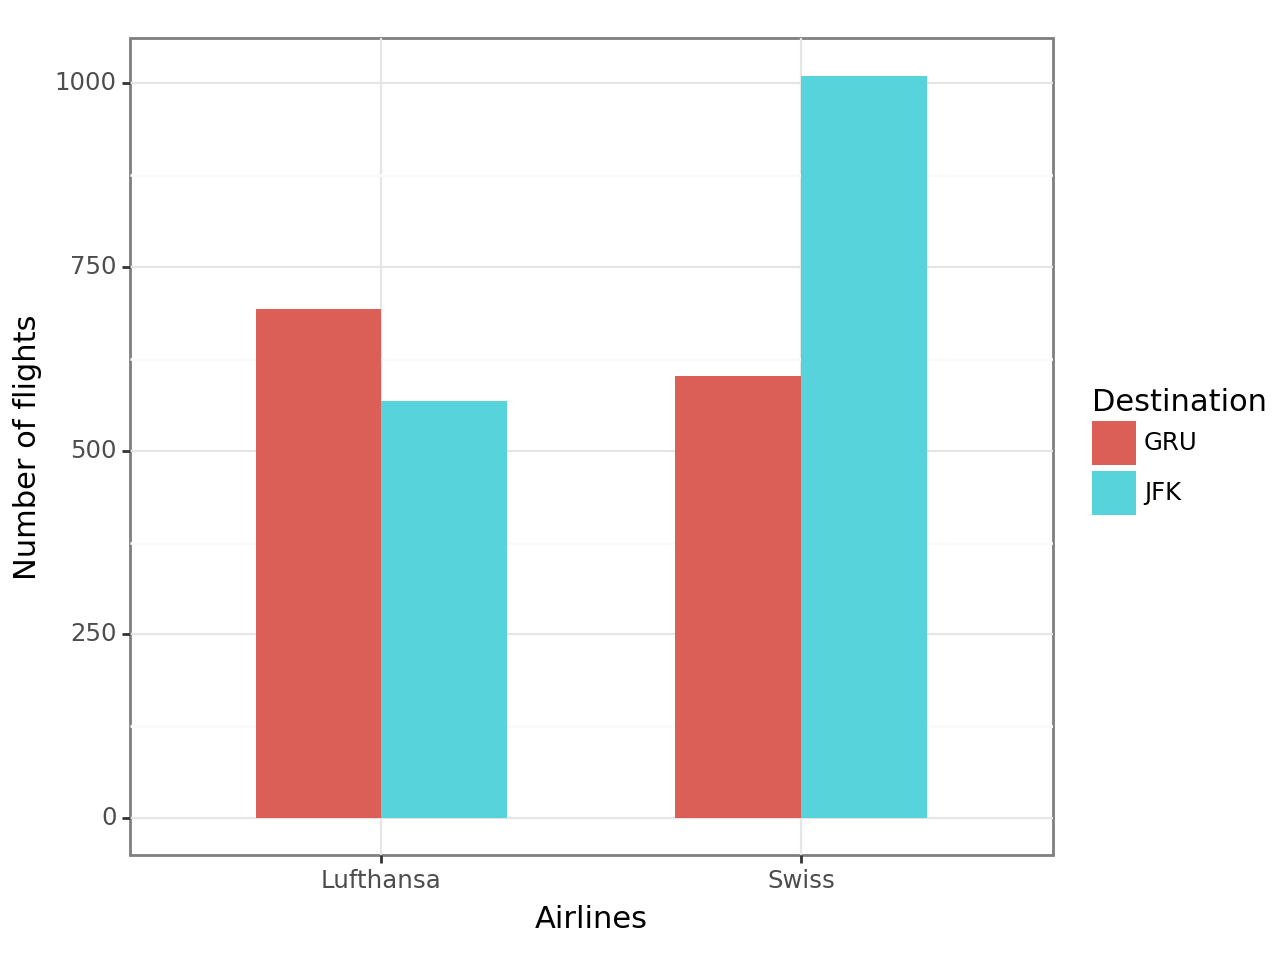

<Figure Size: (640 x 480)>

In [5]:
f1 = (
    ggplot(barplot, aes(x="out_airline_company", y="N", fill="arr_city"))
    + geom_bar(stat="identity", position="dodge", width=0.6, size=0.5)
    + labs(x="Airlines", y="Number of flights", fill="Destination")
    + theme_bw()
    
)
f1

#### b. boxplot

In [6]:
lufthansa_nyc = combined_dataset.loc[(combined_dataset.out_airline_company == 'Lufthansa') & (combined_dataset.arr_city=='JFK')]
swiss_nyc = combined_dataset.loc[(combined_dataset.out_airline_company == 'Swiss') & (combined_dataset.arr_city=='JFK')]
lufthansa_sao = combined_dataset.loc[(combined_dataset.out_airline_company == 'Lufthansa') & (combined_dataset.arr_city=='GRU')]
swiss_sao = combined_dataset.loc[(combined_dataset.out_airline_company == 'Swiss') & (combined_dataset.arr_city=='GRU')]

##### b1. boxplots for New York City

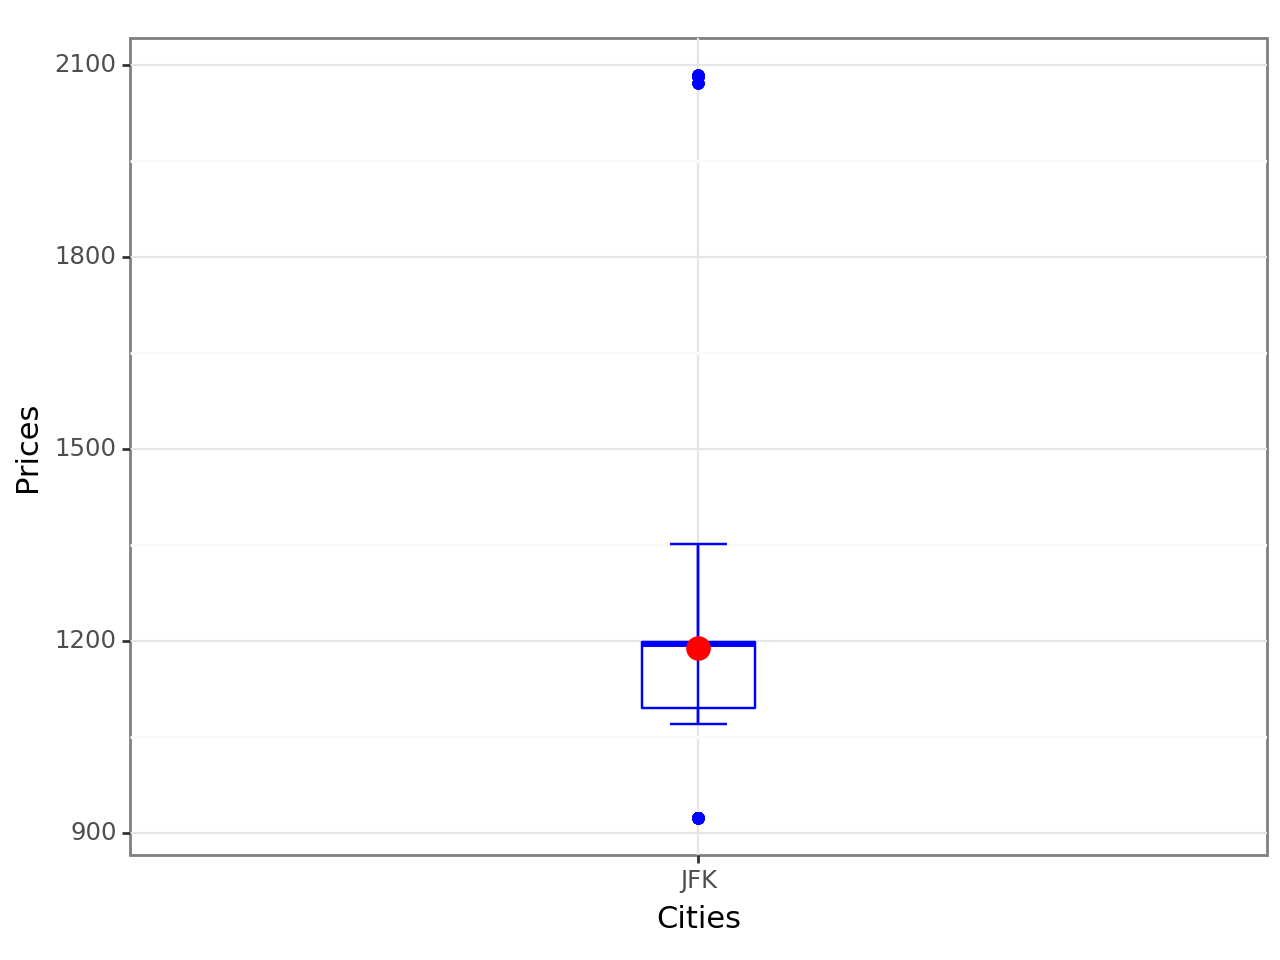

<Figure Size: (640 x 480)>

In [7]:
f2 = (
    ggplot(lufthansa_nyc, aes(y='ticket_price', x='arr_city'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
)
f2

f2 = f2 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
f2

f2 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red")

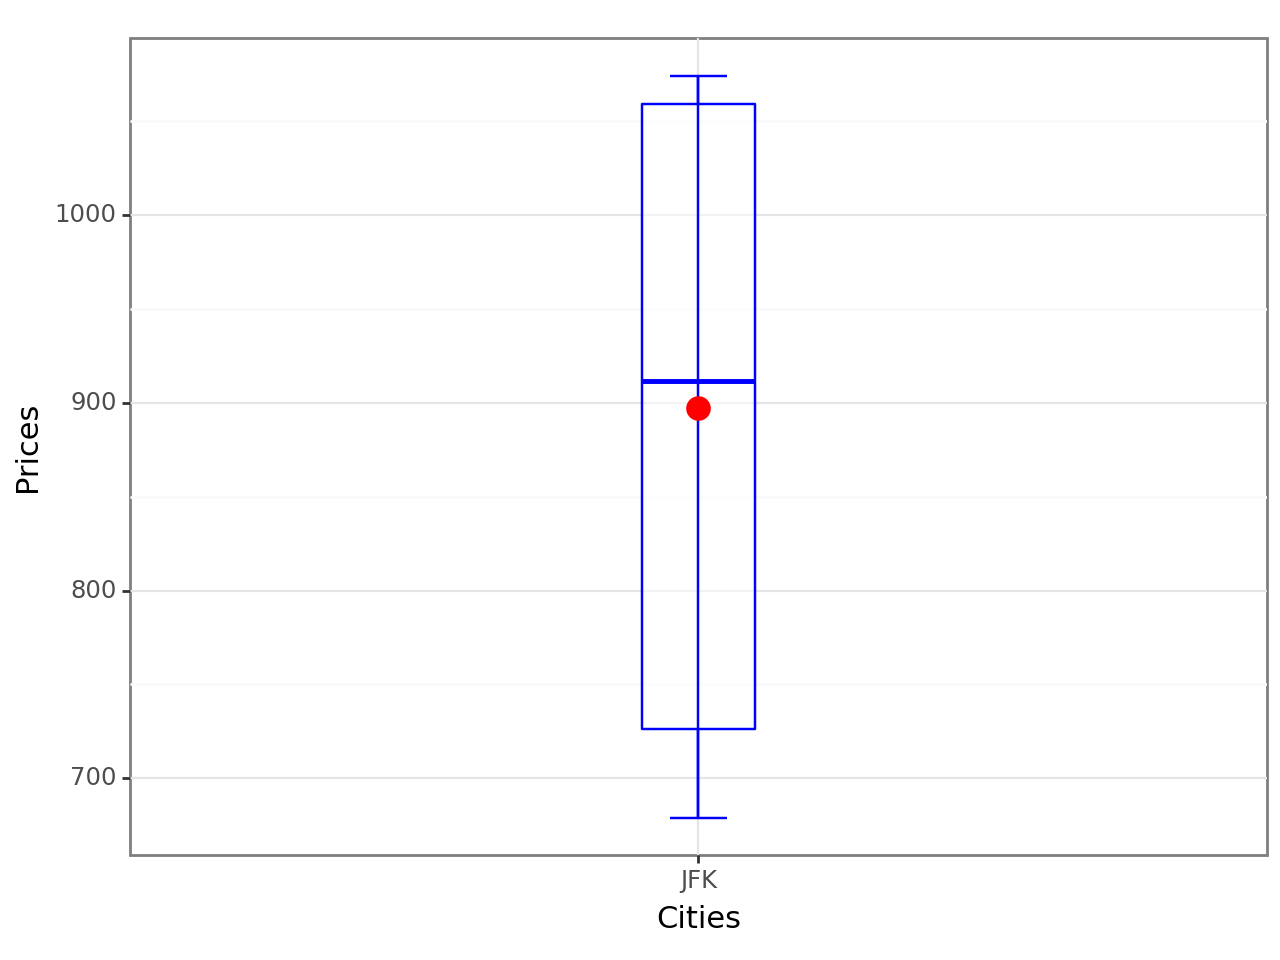

<Figure Size: (640 x 480)>

In [8]:
f3 = (
    ggplot(swiss_nyc, aes(y='ticket_price', x='arr_city'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
)
f3

f3 = f3 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
f3

f3 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red")

##### b2. boxplots for São Paulo destination

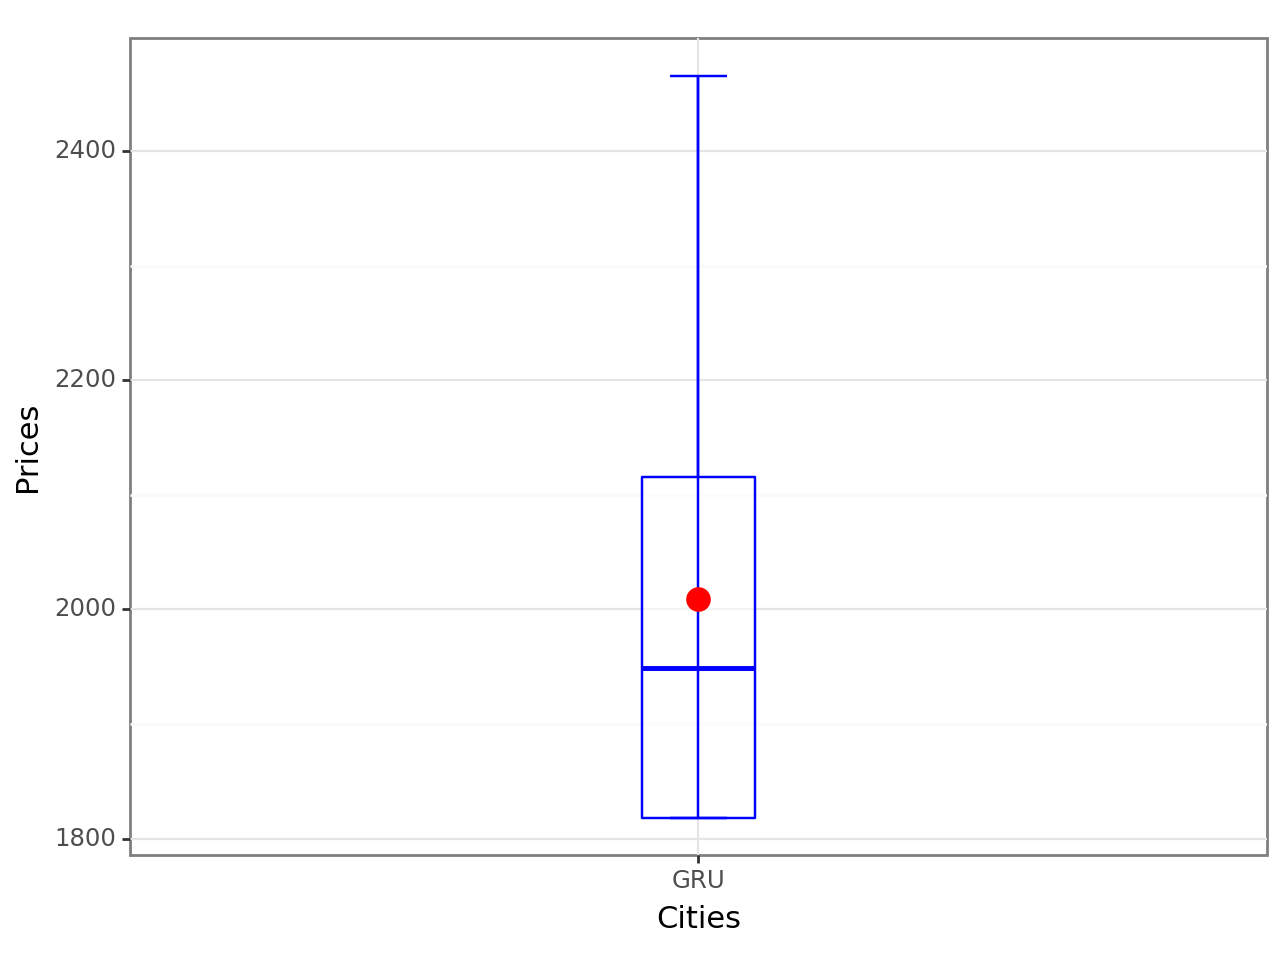

<Figure Size: (640 x 480)>

In [9]:
f4 = (
    ggplot(lufthansa_sao, aes(y='ticket_price', x='arr_city'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
)
f4

f4 = f4 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
f4

f4 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red")

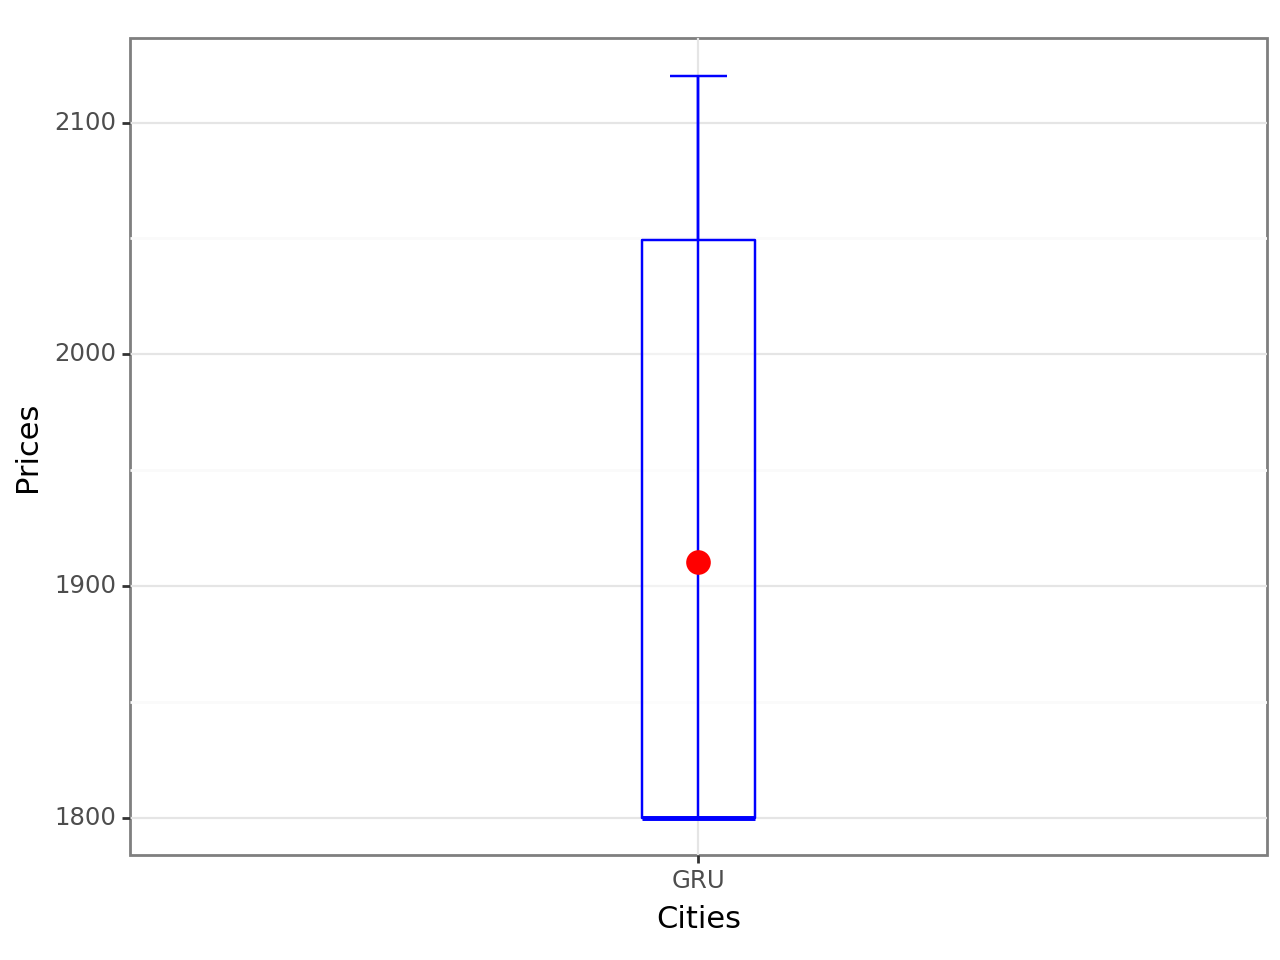

<Figure Size: (640 x 480)>

In [10]:
f5 = (
    ggplot(swiss_sao, aes(y='ticket_price', x='arr_city'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
)
f5

f5 = f5 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
f5

f5 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red")

#### c. lineplot

In [11]:
cur_time = datetime.datetime.now()
month = cur_time.strftime('%b')
year=cur_time.strftime('%Y')

In [12]:
lineplot_nyc = combined_dataset.loc[(combined_dataset.arr_city=='JFK')].groupby(['out_airline_company','day_scrap', 'hour_scrap'])['ticket_price'].agg(['mean'])
lineplot_nyc = lineplot_nyc.reset_index()

lineplot_nyc['date'] = pd.to_datetime(lineplot_nyc['day_scrap'].astype(str) + ' ' + month + ' ' + year + ' '+ lineplot_nyc['hour_scrap'].astype(str), format='%d %b %Y %H')
lineplot_nyc['date'] = lineplot_nyc['date'].dt.strftime('%d %b %I %p')

In [13]:
lineplot_nyc.head()

,out_airline_company,day_scrap,hour_scrap,mean,date
0,Lufthansa,20,16,1133.220556,20 May 04 PM
1,Lufthansa,20,18,1131.853333,20 May 06 PM
2,Lufthansa,20,20,1105.545000,20 May 08 PM
3,Lufthansa,20,22,1134.216111,20 May 10 PM
4,Lufthansa,21,8,1129.710000,21 May 08 AM


In [14]:
date_nyc = lineplot_nyc[lineplot_nyc.out_airline_company == 'Lufthansa']['date'].tolist()
price_lufthansa_nyc = lineplot_nyc[lineplot_nyc.out_airline_company == 'Lufthansa']['mean'].tolist()
price_swiss_nyc = lineplot_nyc[lineplot_nyc.out_airline_company == 'Swiss']['mean'].tolist()

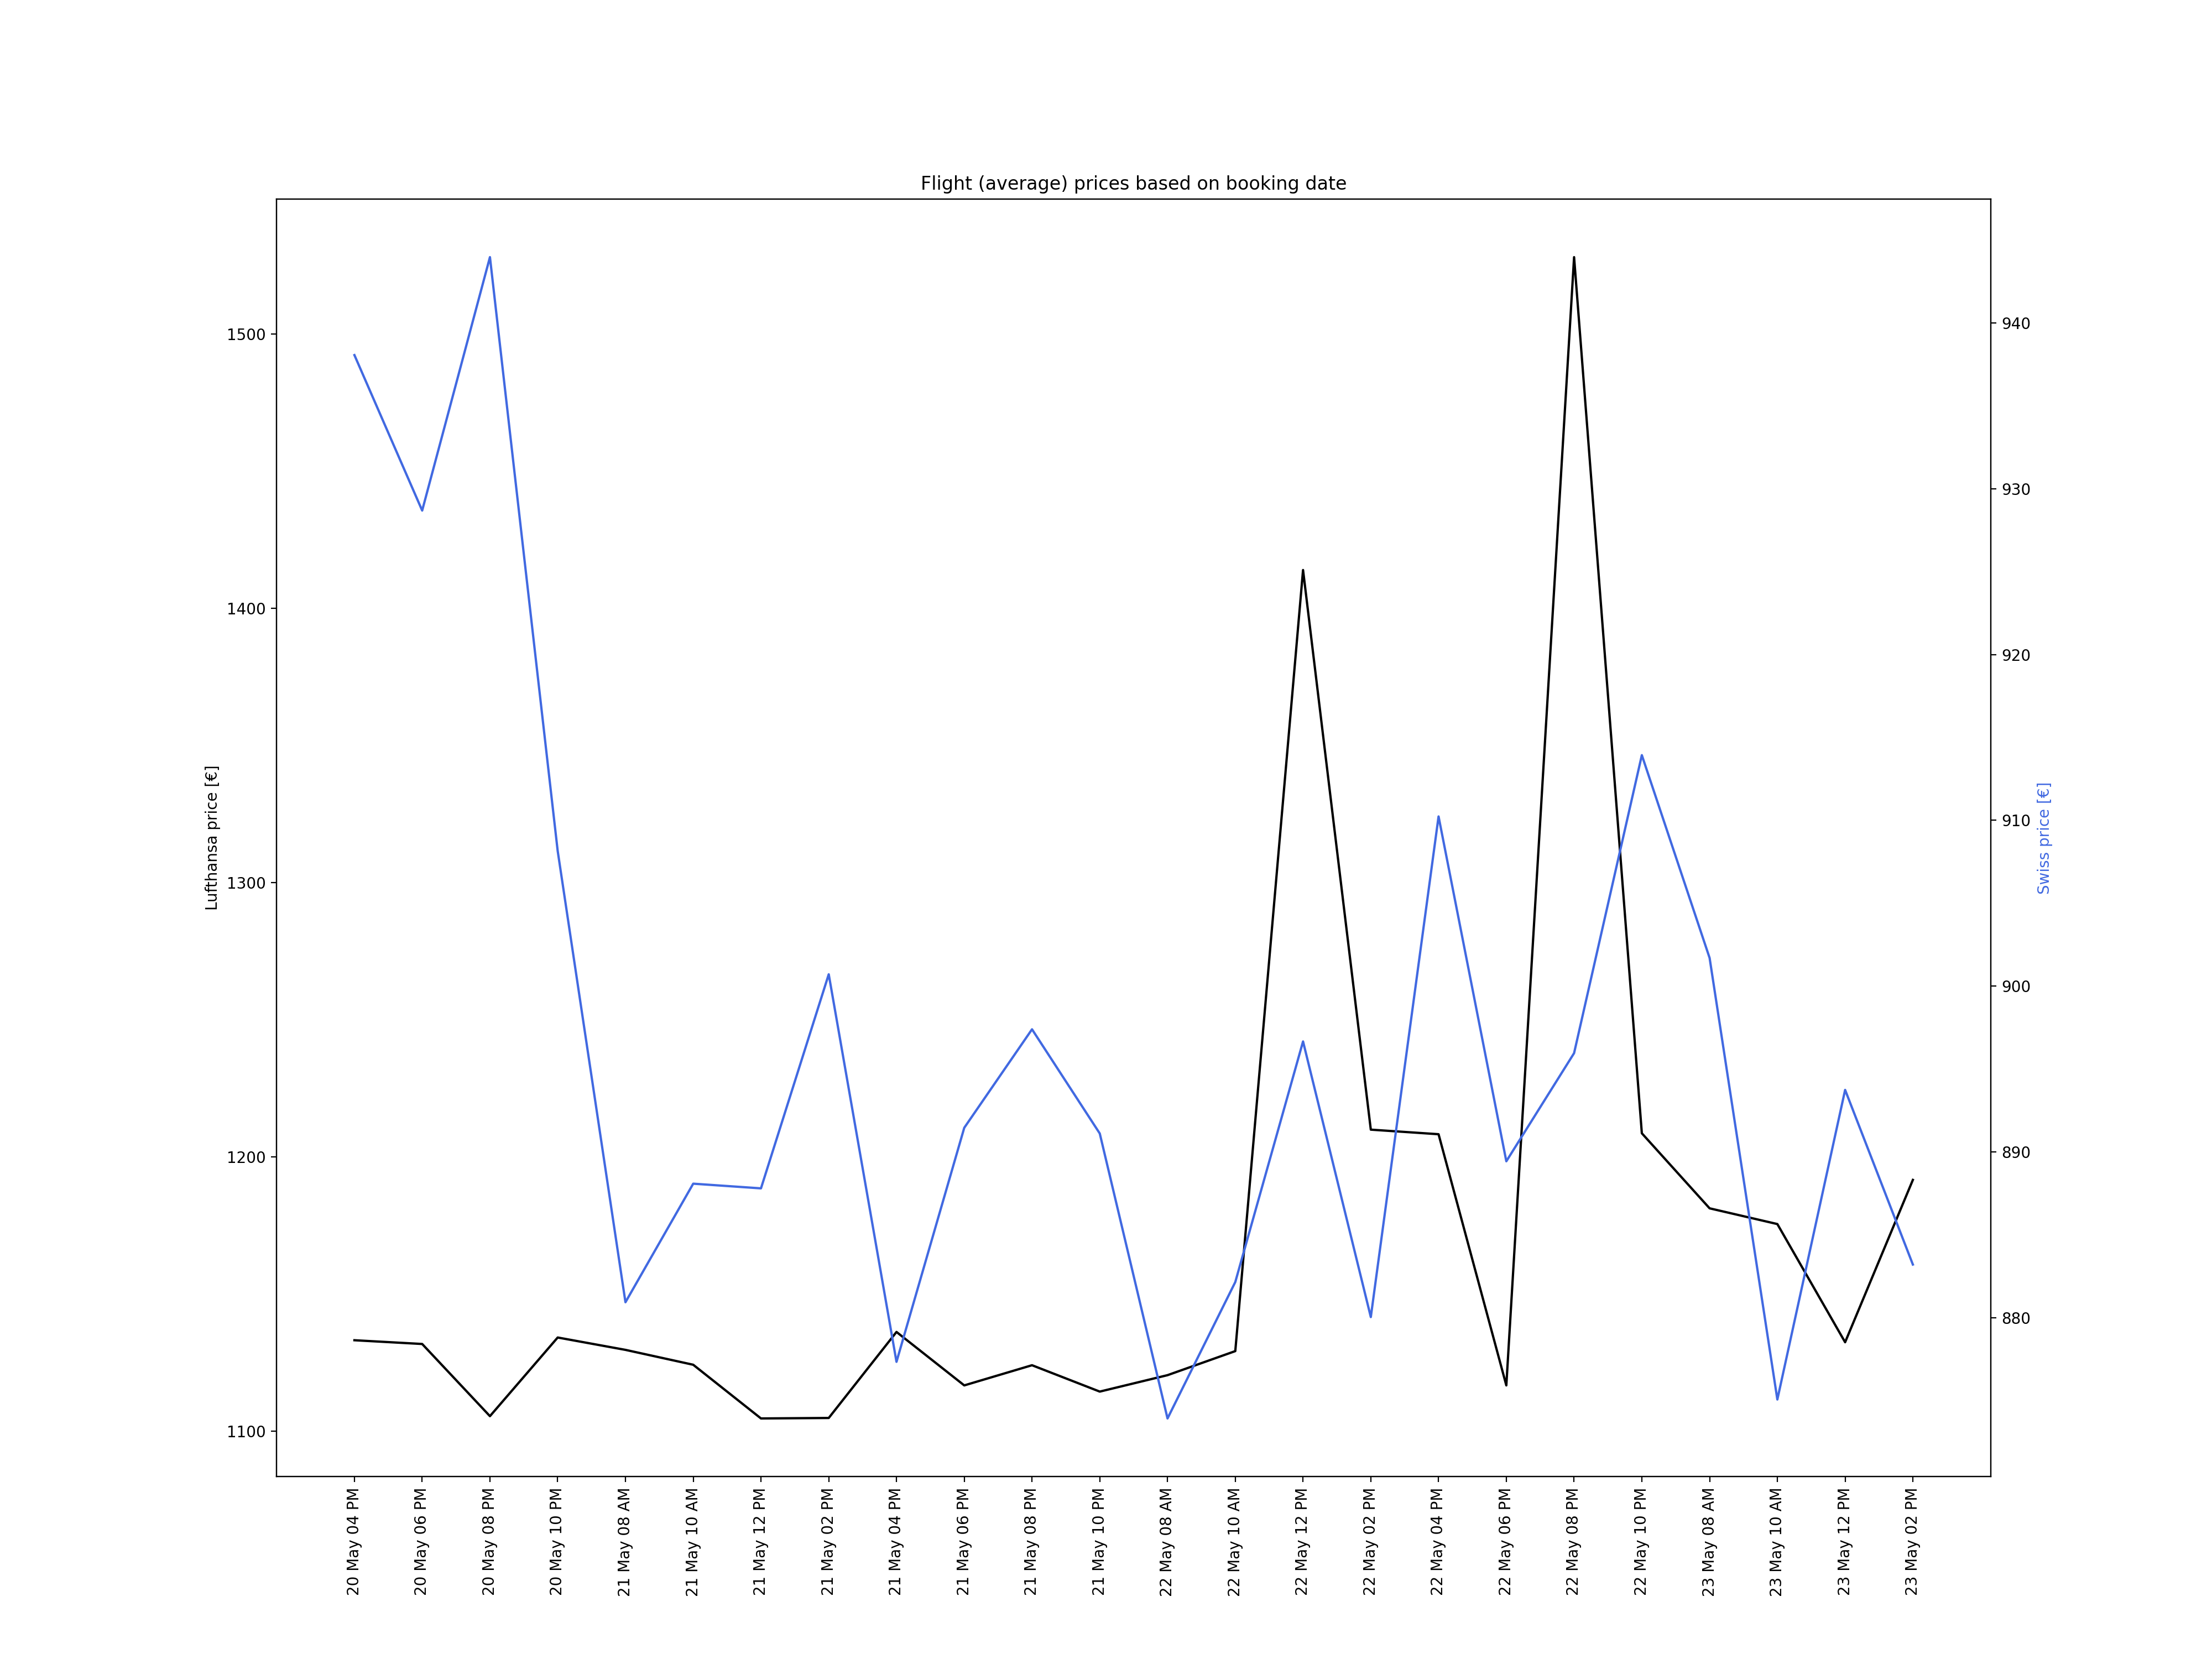

In [25]:
fig, ax1 = plt.subplots(figsize = (20,15))

ax1.plot(date_nyc, price_lufthansa_nyc, color = 'k')
plt.xticks(rotation=90)
ax1.set_ylabel("Lufthansa price [€]", color = 'k')
ax2 = ax1.twinx()
ax2.plot(date_nyc, price_swiss_nyc, color = "royalblue")
ax2.set_ylabel("Swiss price [€]", color = "royalblue")
plt.xticks(rotation=90)
plt.title('Flight (average) prices based on booking date');